# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# !pip install scipy
# !pip install Pillow
# !pip install imageio
# !pip install tensorflow
# !pip install matplotlib
# !pip install opencv-python

In [2]:
import numpy as np
import os
import imageio
import datetime
import os
import cv2
from scipy import misc

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.compat.v1.random.set_random_seed(30)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 100 #experiment with the batch size

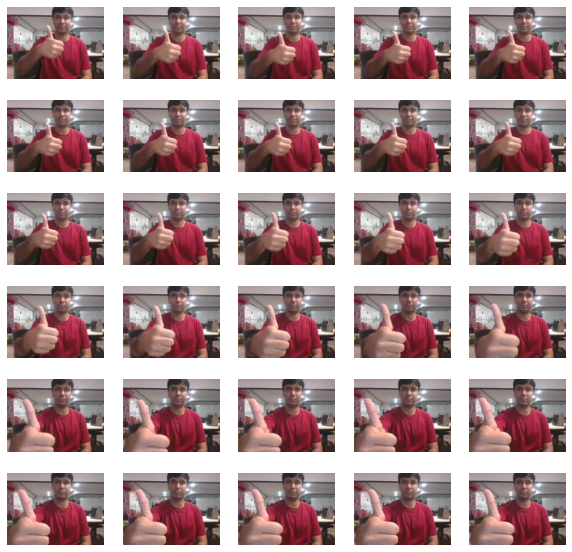

In [5]:
## Pick some random sequence
import matplotlib.pyplot as plt

data_dir_train = 'Project_data/train/'
random_sequence = train_doc[np.random.randint(len(train_doc))].strip().split(';')[0]+'/'
images = os.listdir(data_dir_train + random_sequence)
# Create a code to visualize one instance of all the 30 images present in the sequence
plt.figure(figsize=(10, 10))
i = 0
random_images = []
for img in images:
  ax = plt.subplot(6, 5, i + 1)
  i = i + 1
  random_images.append(os.path.join(data_dir_train, random_sequence, img))
  img_bgr = cv2.imread(os.path.join(data_dir_train, random_sequence, img))
  img_mp = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # This is needed because opencv uses BGR convention and matplotlib uses RGB
  imgplot= plt.imshow(img_mp)
  plt.axis("off")
  plt.plot()

(120, 160, 3)


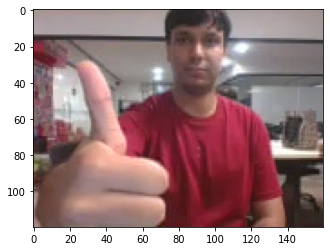

In [6]:
# Random Image - Original
random_image = random_images[np.random.randint(30)]
image_bgr = cv2.imread(random_image)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
print(image_bgr.shape)

(110, 150, 3)


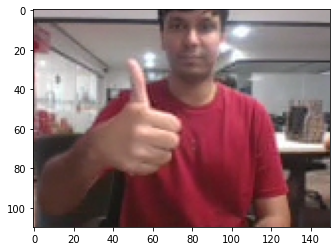

In [7]:
## Cropped Image Sample
crop_img = image_bgr[10:120, 10:160]
plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))
print(crop_img.shape)

(120, 120, 3)


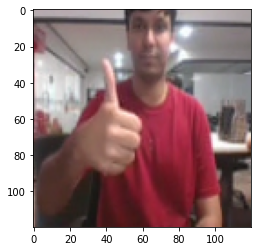

In [8]:
# Resize Image Sample
dim = (120, 120)
resized_img = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
print(resized_img.shape)

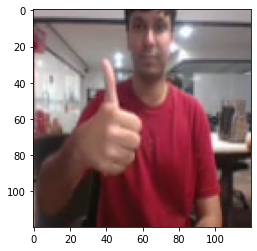

In [9]:
# Normalized Image
plt.imshow(cv2.cvtColor(cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), cv2.COLOR_BGR2RGB))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(1,10) #create a list of image numbers you want to use for a particular video
    x = 10
    y = 120
    z = 120
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # cropping the image
                    image_x = image.shape[0]
                    image_y = image.shape[1]
                    
                    image_cropped = image[10:image_x, 10:image_y]

                    dim = (y, z)
                    image_resized = cv2.resize(image_cropped, dim, interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = cv2.normalize(image_resized[:,:,0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    batch_data[folder,idx,:,:,1] = cv2.normalize(image_resized[:,:,1], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    batch_data[folder,idx,:,:,2] = cv2.normalize(image_resized[:,:,2], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
g = generator(data_dir_train, train_doc, 663)
next(g)

Source path =  Project_data/train/ ; batch size = 663


    ...,
           [0.04449198, 0.1187251 , 0.12380198],
           [0.12427807, 0.19739226, 0.20400663],
           [0.05597148, 0.12292648, 0.13050371]],
 
          [[0.43429592, 0.67316192, 0.81285578],
           [0.39893049, 0.61999285, 0.74944156],
           [0.45818186, 0.67258245, 0.79008436],
           ...,
           [0.03935829, 0.10612097, 0.10247172],
           [0.13048127, 0.21238682, 0.2084024 ],
           [0.0514795 , 0.12879391, 0.12826979]],
 
          [[0.47137257, 0.71155381, 0.85176915],
           [0.17647059, 0.39760959, 0.51884419],
           [0.26352945, 0.4741036 , 0.58542913],
           ...,
           [0.10352942, 0.19521914, 0.1875045 ],
           [0.        , 0.04940239, 0.04482237],
           [0.13490197, 0.21354583, 0.20969951]]],
 
 
         [[[0.49098042, 0.73219627, 0.74304342],
           [0.49411771, 0.73540348, 0.74626541],
           [0.50117654, 0.74021435, 0.75351495],
           ...,
           [0.71215695, 0.93024278, 0.89125663],


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Final_data/train'
val_path = 'Final_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser =  'sgd' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)